# **AI Projekt Jarin Schnierl**
## **Image Classification**

---



### Imports and Requirements
---

In [1]:
pip install datasets transformers torchvision torchaudio pytorch-lightning matplotlib evaluate "accelerate>=0.26.0"


Note: you may need to restart the kernel to use updated packages.


In [3]:
import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [5]:


# Food-101 laden (enthält 'train' und 'validation')
dataset = load_dataset("food101")

train-00001-of-00008.parquet:  31%|###1      | 210M/674M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [6]:
# Food-101 auf Subset reduzieren
dataset["train"] = dataset["train"].select(range(5000))          # z. B. 5k Trainingsbeispiele
dataset["validation"] = dataset["validation"].select(range(1000))  # z. B. 1k Validierungsbeispiele


In [4]:
# Login onto Hugging Face hub to load any private dataset/model.
# We need to login as we'll also upload our model to the hub
notebook_login()

Token has not been saved to git credential helper.


In [8]:
dataset['train'][0]

{'image': <PIL.Image.Image image mode=RGB size=384x512>, 'label': 6}

In [9]:
labels = dataset["train"].features["label"].names
print(len(labels),labels)

101 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso

#### Let's see some sample images from our dataset
---

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method.

In [10]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch  # Wichtig für Tensor-Verarbeitung

# Augmentierung & Preprocessing
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Mapping-Funktion für Hugging Face Dataset
def transform_example(example, transform):
    image = Image.fromarray(np.array(example["image"]))
    tensor = transform(image)

    if not isinstance(tensor, torch.Tensor):
        tensor = torch.tensor(tensor)

    return {"pixel_values": tensor, "label": int(example["label"])}

# Dataset transformieren (Food-101 Subset)
processed_dataset = {
    "train": dataset["train"].map(lambda x: transform_example(x, train_transforms), batched=False),
    "validation": dataset["validation"].map(lambda x: transform_example(x, val_transforms), batched=False)
}

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

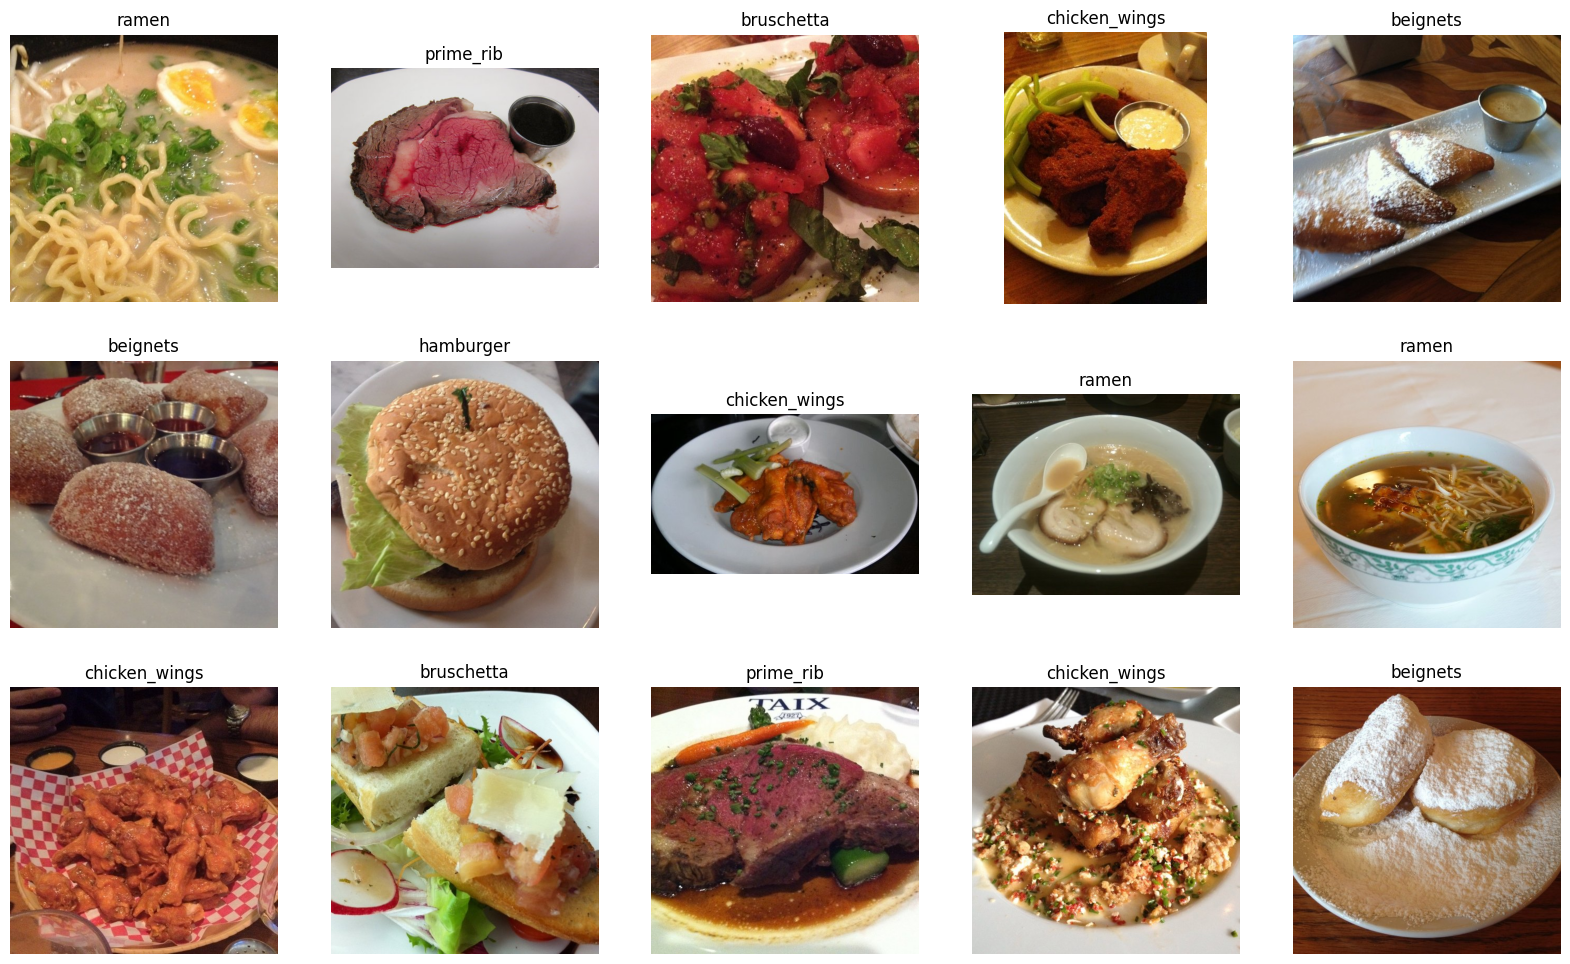

In [11]:
def show_samples(ds, rows, cols):
    # Mapping von int → Labelname
    id2label = ds.features['label'].int2str

    samples = ds.shuffle(seed=42).select(np.arange(rows * cols))  # zufällige Bilder
    fig = plt.figure(figsize=(cols * 4, rows * 4))

    for i in range(rows * cols):
        img = samples[i]['image']
        label_idx = samples[i]['label']
        label = id2label(label_idx)  # z. B. "prime_rib"
        
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

# Beispielaufruf
show_samples(dataset['train'], rows=3, cols=5)

In [11]:
our_dataset = DatasetDict({
    'train': dataset['train'],
    'validation': dataset['validation']
})

In [12]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

In [13]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [29]:
def collate_fn(batch):
    pixel_values = torch.stack([
        x["pixel_values"] if isinstance(x["pixel_values"], torch.Tensor) else torch.tensor(x["pixel_values"])
        for x in batch
    ])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

#### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for `labels`, the shape should be `(batch,)`

## Let's see how to calculate the metrics
---

We can use Hugging Face `evaluate` library to calculate the metrics. For image classification, we can use the accuracy metric.

In [16]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

## Loading our Model
---

We will use [ViTForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) to load our pre-trained model.

We do need to update the final classification layer, to output predictions equal to the number of labels in our dataset.
We will do that by passing in `num_labels` argument along with our label mappings `id2label` and `label2id`.

We also need to pass `ignore_mismatched_sizes = True` to compensate for the change in number of parameters in the classification layer.

In [17]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Here's the architecture of our model

In [18]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

Since we are not going to update the entire model, we can "freeze" all the parameters except for the new `classifier` layer by setting `requires_grad` to False for each layer's parameters.

In [19]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

We can check how many parameters are there in the model along with how many are actually going to be trained now.

In [20]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,876,325 | trainable_params = 77,669


# Let's commence our training 🚀️🚀️🚀️
---

We'll be using [Hugging Face Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer) to train our model. Feel free to choose your training arguments such as the batch size, learning rate, number of epochs, logging options, etc.

With respect to image classification, we do need to set `remove_unused_columns=False` to prevent the `image` column in our dataset to be removed, since it is the one being used to create our `pixel_values` inputs.

In [30]:
training_args = TrainingArguments(
    output_dir="./vit-base-food101",
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
    run_name="transferlearning-google_vit-base-patch16-224 no data augmentation"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.387900,0.134065,0.966000
2,0.287500,0.104896,0.966000
3,0.268400,0.091923,0.970000
4,0.238700,0.088749,0.972000
5,0.228700,0.089582,0.972000


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1565, training_loss=0.36533053705867485, metrics={'train_runtime': 7908.7981, 'train_samples_per_second': 3.161, 'train_steps_per_second': 0.198, 'total_flos': 1.93901871744e+18, 'train_loss': 0.36533053705867485, 'epoch': 5.0})

### evaluating on our test dataset

### let's look at some of the predictions made by our new model!

In [34]:
def show_predictions(rows, cols):
    samples = our_dataset['validation'].shuffle().select(np.arange(rows * cols))
    processed_samples = samples.with_transform(lambda x: transform_example(x, val_transforms))
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)  # predicted labels from logits

    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')


### Our model works really well! Let's save it and also push it to Hugging Face model hub!

In [35]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "dataset": 'food101',
    "tasks": "image-classification",
    "tags": ['image-classification'],
}

In [36]:
trainer.save_model()
trainer.push_to_hub('🐕️🐈️', **kwargs)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1748634081.ip-10-192-10-142.33402.3:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jarinschnierl/vit-base-food101/commit/290c11056c726502986502447562bb3f980421e0', commit_message='🐕️🐈️', commit_description='', oid='290c11056c726502986502447562bb3f980421e0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jarinschnierl/vit-base-food101', endpoint='https://huggingface.co', repo_type='model', repo_id='jarinschnierl/vit-base-food101'), pr_revision=None, pr_num=None)

In [6]:
from transformers import AutoImageProcessor

# Der gleiche Prozessor, den du beim Training verwendet hast
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# In deinen Modellordner speichern (lokal)
processor.save_pretrained("vit-base-food101")

processor.push_to_hub("jarinschnierl/vit-base-food101")


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


CommitInfo(commit_url='https://huggingface.co/jarinschnierl/vit-base-food101/commit/b26e3b30c2dabecaf1965d6513311909928a9e7c', commit_message='Upload processor', commit_description='', oid='b26e3b30c2dabecaf1965d6513311909928a9e7c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jarinschnierl/vit-base-food101', endpoint='https://huggingface.co', repo_type='model', repo_id='jarinschnierl/vit-base-food101'), pr_revision=None, pr_num=None)